# <u> Part 1: Pair Identification

## Install Package

In [1]:
!pip install kneed
from kneed import KneeLocator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE

from statsmodels.tsa.stattools import coint

from itertools import cycle

import scipy.cluster.hierarchy as shc

import warnings
warnings.filterwarnings('ignore')

## Data Importing & Cleaning

In [2]:
stockdata = pd.read_excel('commod_data.xlsx')

In [3]:
stockdata["Date"] = pd.to_datetime(stockdata['Date'], format="%Y-%m-%d")

In [4]:
stockdata = stockdata.loc[(stockdata["Date"] >= '2009-01-01')
                     & (stockdata["Date"] < '2017-12-31')]

In [5]:
# Data Import
stockdata = stockdata.iloc[: , 1:].pct_change()
stockdata = stockdata.iloc[1: , :]
stockdata

,CRUDOIL,GOLDBLN,LCPCASH,EIAEBRT,OILBREN,WHEATSF,LAHCASH,LNICASH,CORNUS2,SILVERH,...,FUELOIL,NATBGAS,EEXPEAK,DAPNOCB,WSUGDLY,WOLAWCE,WSUGDLY.1,PAOLMAL,USTEERS,MILKGDA
110,0.039013,0.017571,0.051862,0.198772,0.070640,0.000000,0.020395,0.129296,0.013228,0.043557,...,0.044256,-0.056589,0.506681,0.000000,0.000000,0.012192,0.074171,0.046296,0.007300,0.000000
111,0.053302,-0.031116,-0.015471,0.067536,0.144588,0.000000,-0.014625,-0.027307,-0.005222,-0.088696,...,0.053368,0.039607,-0.083266,0.007692,0.000000,0.013887,0.001625,0.035398,0.004325,-0.023529
112,-0.004712,-0.005353,0.064444,0.066536,0.065301,0.053279,0.036609,0.031760,0.044619,0.069656,...,0.047943,0.065718,-0.055613,0.000000,0.000000,-0.001468,0.034063,0.008547,0.000000,0.000000
113,-0.122478,0.001478,-0.013794,-0.054408,-0.051786,-0.062257,-0.008272,-0.071749,-0.035176,0.000000,...,-0.081917,0.000146,0.428361,0.000000,0.000000,0.001750,-0.021961,0.000000,0.000000,0.000000
114,-0.021816,0.013050,-0.043925,-0.071166,-0.014044,-0.012448,-0.024543,-0.061492,-0.020833,-0.011597,...,0.020202,-0.037055,0.189397,0.000000,0.009772,-0.007894,0.000000,-0.033898,-0.009311,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.600575,0.000000,0.000000,0.000000,0.000000,0.000000,0.002172,0.000000
2452,0.031831,0.006451,0.000000,0.000000,0.000000,-0.006993,0.000000,0.000000,0.006211,0.007313,...,0.039121,-0.000037,-1.693773,0.000000,0.000000,0.000130,0.000000,0.000000,0.000000,-0.022556
2453,-0.005503,0.002784,0.016549,0.021978,0.023267,0.016432,0.027736,-0.001988,0.003086,0.009679,...,-0.003167,-0.030610,-4.648456,0.000000,0.000000,0.005959,0.019890,0.024793,0.000000,0.015385
2454,0.003353,0.006228,0.007151,0.011661,0.004066,0.000000,0.014609,0.020459,-0.006154,0.008987,...,0.010966,0.027541,-0.121665,0.000000,-0.002222,0.003413,0.004035,0.008065,0.000000,0.015152


In [6]:
# Data Preparation
returns = stockdata.mean()*259
returns = pd.DataFrame(returns)
returns.columns = ['returns']
returns['volatility'] = stockdata.std()*np.sqrt(259)

# Normalization
scale = StandardScaler().fit(returns)
scaled_data = pd.DataFrame(scale.fit_transform(returns),columns = returns.columns, index = returns.index)
X = scaled_data

In [7]:
X.sort_values(by='returns', ascending=False)

,returns,volatility
ELEPJMP,5.388525,3.249884
ELEPJMB,4.916699,3.659100
EEXBASE,1.948366,4.903566
EEXPEAK,1.637127,3.288423
PALLADM,-0.159496,-0.260735
...,...,...
SOYBEAN,-0.270700,-0.303641
PLATFRE,-0.270785,-0.329465
COCINUS,-0.284667,-0.297261
MILKGDA,-0.286840,-0.337971


## Pair Selection

### K-Means Clustering

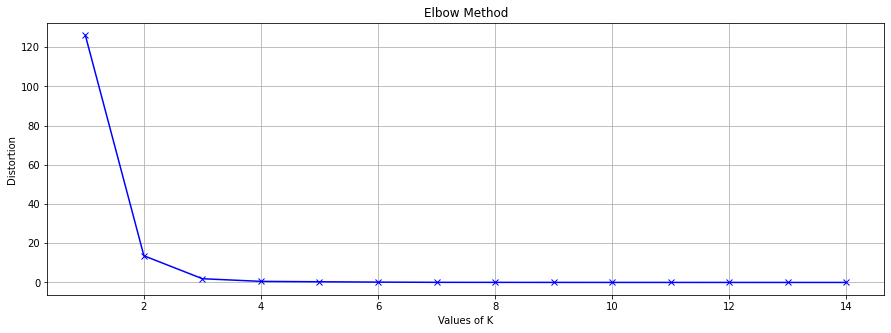

Suggested number of clusters:  3


In [8]:
# Optimize K - Distortion Method
K = range(1,15)
distortions = []

# Fit Model
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

# Plot
fig = plt.figure(figsize= (15,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
print('Suggested number of clusters: ', kl.elbow)

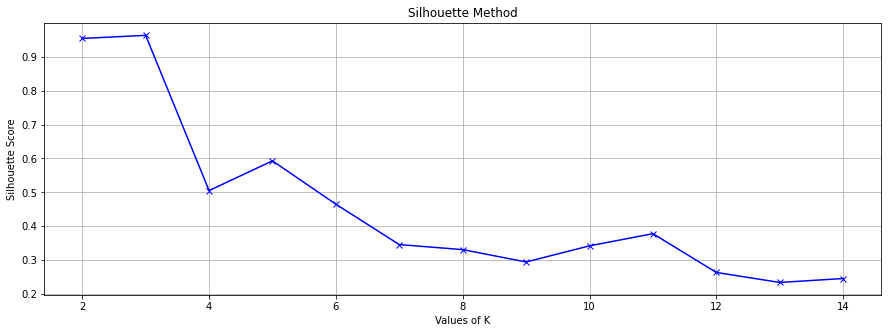

Suggested number of clusters:  4


In [9]:
# Optimize K - Silhouettes Method
K = range(2,15)
silhouettes = []

# Fit Model
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='random')
    kmeans.fit(X)
    silhouettes.append(silhouette_score(X, kmeans.labels_))

# Plot
fig = plt.figure(figsize= (15,5))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.grid(True)
plt.show()

kl = KneeLocator(K, silhouettes, curve="convex", direction="decreasing")
print('Suggested number of clusters: ', 4)

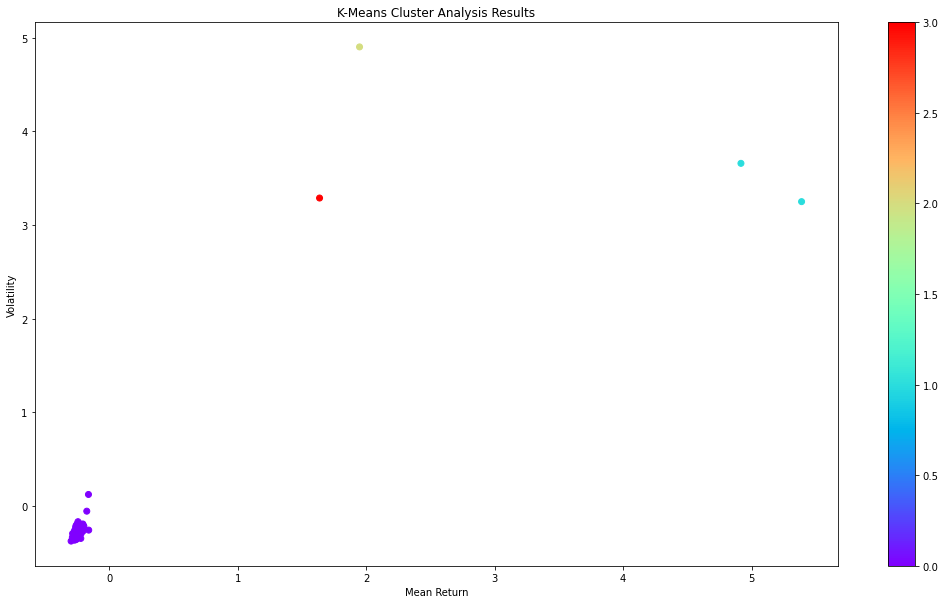

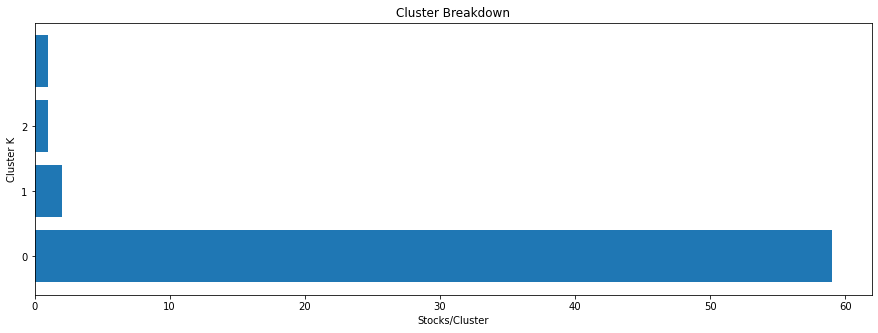

In [10]:
# Optimal K Cluster = 4
c = 4

# Fit Model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
labels = k_means.predict(X)

# Plot
fig = plt.figure(figsize = (18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c=labels, cmap="rainbow", label = X.index)
ax.set_title('K-Means Cluster Analysis Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

# Plot
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
fig = plt.figure(figsize= (15,5))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Cluster Breakdown')
plt.xlabel('Stocks/Cluster')
plt.ylabel('Cluster K')
y = [0,1,2]
plt.yticks(y)
plt.show()

### Hierarchical Clustering

Suggested number of clusters:  5


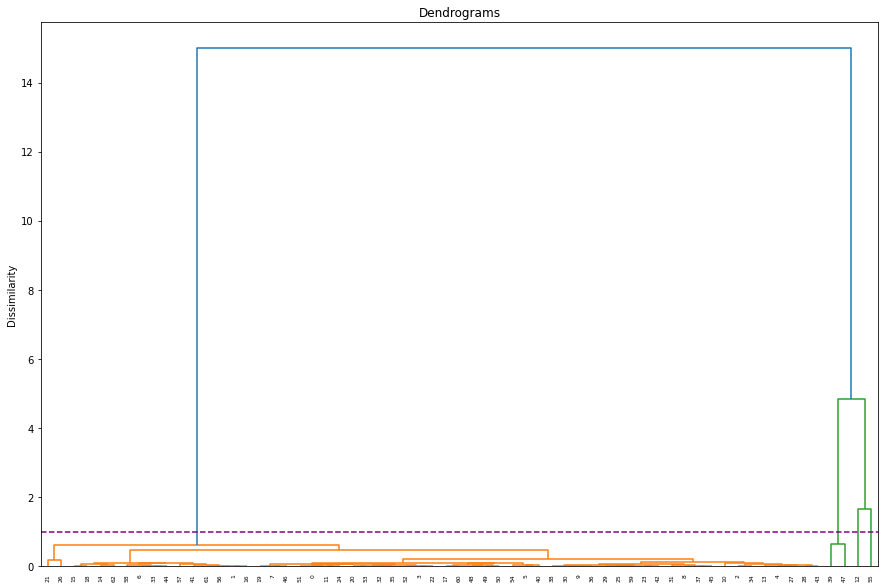

In [11]:
# Optimize Dissimilarity

# Plot
plt.figure(figsize=(15, 10))  
plt.title("Dendrograms")  
plt.ylabel('Dissimilarity')
dend = shc.dendrogram(shc.linkage(X, method='ward'))
plt.axhline(y=1, color='purple', linestyle='--')

print('Suggested number of clusters: ', 5)

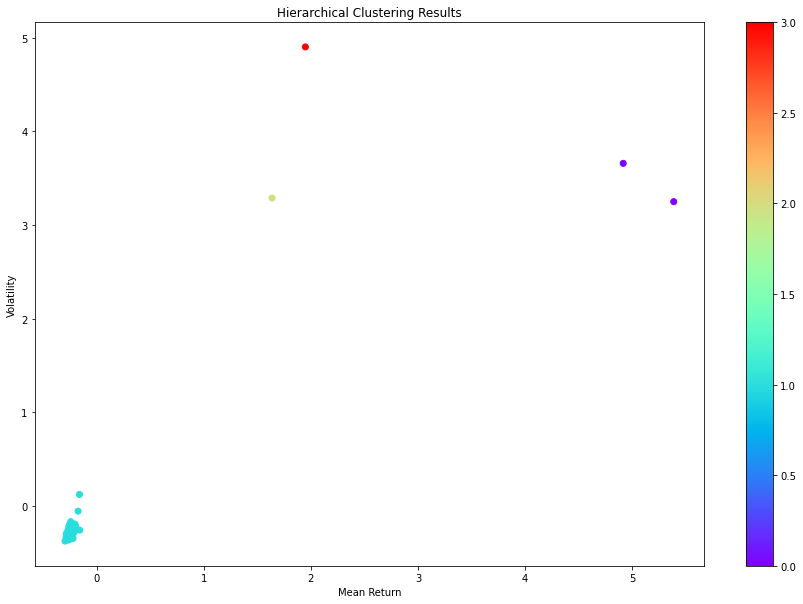

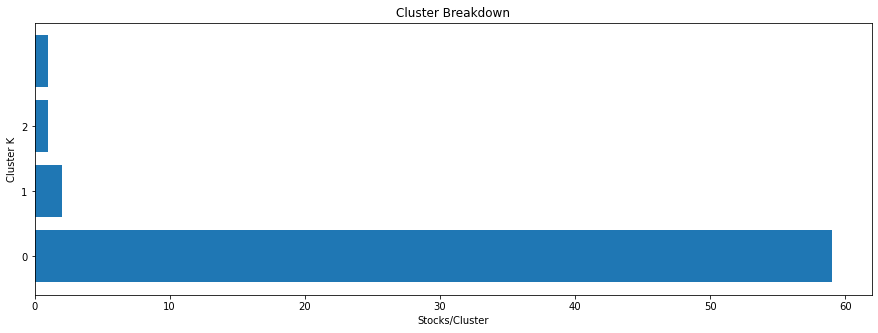

In [12]:
# Fit Model
clusters = 4
hc = AgglomerativeClustering(n_clusters= clusters, affinity='euclidean', linkage='ward')
labels = hc.fit_predict(X)

# Plot
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels, cmap='rainbow')
ax.set_title('Hierarchical Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

# Plot
clustered_series = pd.Series(index=X.index, data=hc.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=hc.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
fig = plt.figure(figsize= (15,5))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Cluster Breakdown')
plt.xlabel('Stocks/Cluster')
plt.ylabel('Cluster K')
y = [0,1,2]
plt.yticks(y)
plt.show()

### Affinity Propagation Clustering

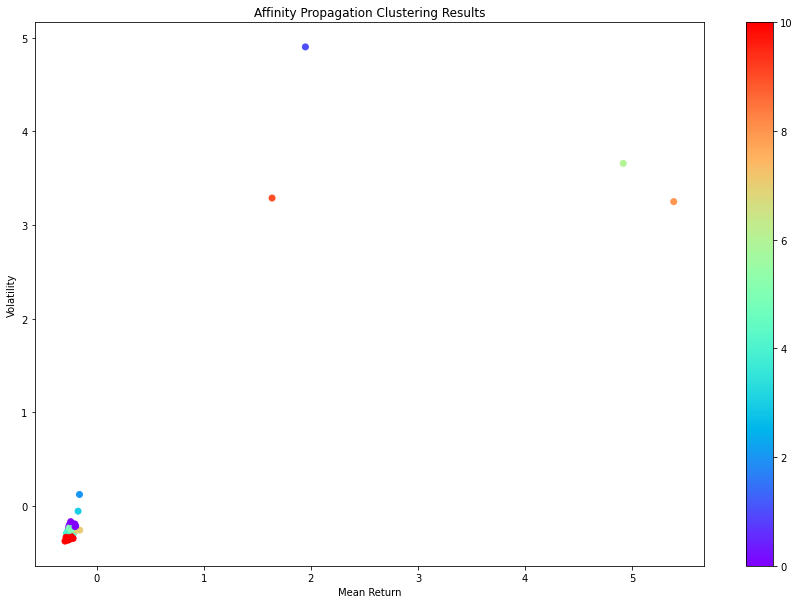

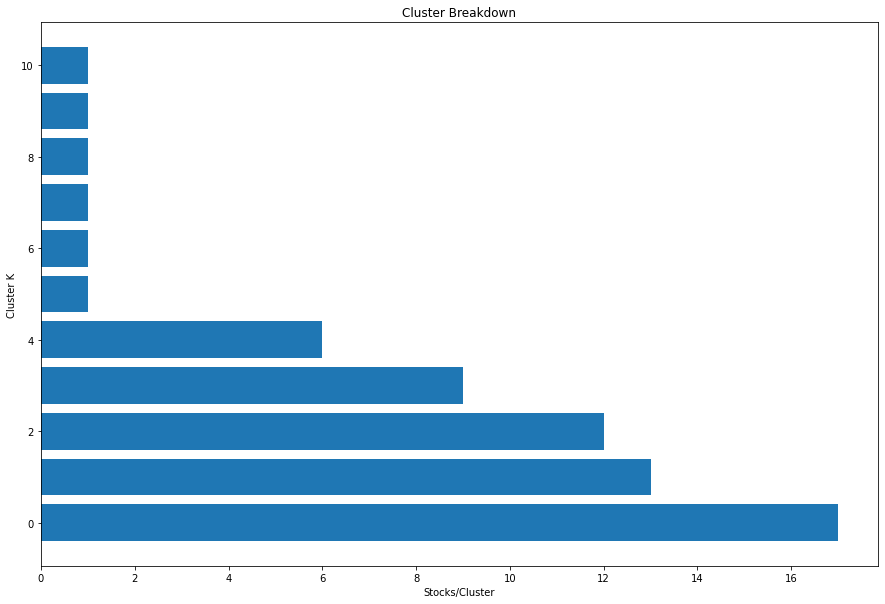

In [13]:
# Fit Model
ap = AffinityPropagation()
ap.fit(X)
labels = ap.predict(X)

# Plot
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels, cmap='rainbow')
ax.set_title('Affinity Propagation Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

# Plot
clustered_series = pd.Series(index=X.index, data=ap.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=ap.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
fig = plt.figure(figsize= (15,10))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Cluster Breakdown')
plt.xlabel('Stocks/Cluster')
plt.ylabel('Cluster K')
plt.show()

The number of clusters is: 11


<Figure size 432x288 with 0 Axes>

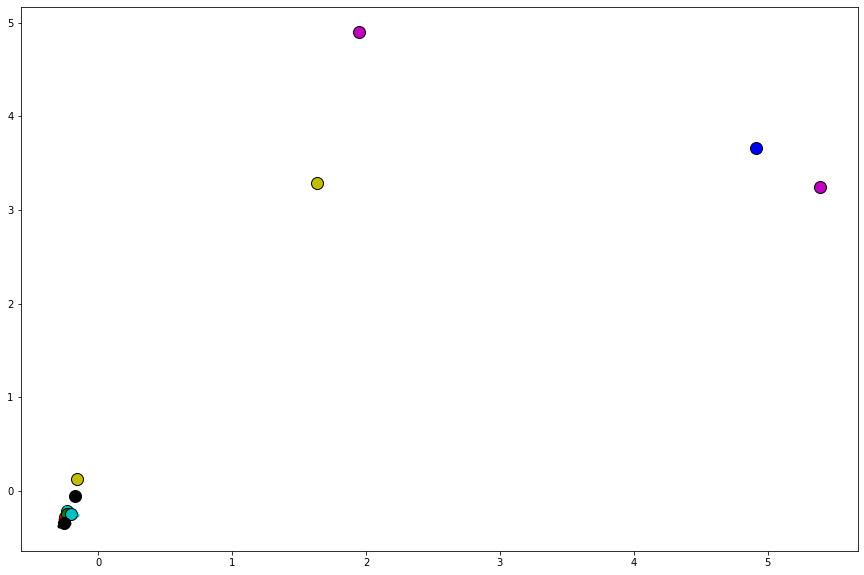

In [14]:
# Extract Cluster Centre
cci = ap.cluster_centers_indices_
labels = ap.labels_
clusters = len(cci)
print('The number of clusters is:',clusters)

# Plot
X_ap = np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf
fig=plt.figure(figsize=(15,10))
colors = cycle('cmykrgbcmykrgbcmykrgbcmykrgb')
for k, col in zip(range(clusters),colors):
    cluster_members = labels == k
    cluster_center = X_ap[cci[k]]
    plt.plot(X_ap[cluster_members, 0], X_ap[cluster_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=12)
    for x in X_ap[cluster_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)
plt.show()

## Clustering Evaluation

In [15]:
print("K-Means Clustering", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("Hierarchical Clustering", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("Affinity Propagation Clustering", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

K-Means Clustering 0.9431186161563241
Hierarchical Clustering 0.9431186161563241
Affinity Propagation Clustering 0.2974326177112519


## Selection Framework

In [16]:
# Clusters & Pairs Breakdown 
cluster_size_limit = 1000
counts = clustered_series.value_counts()
ticker_count = counts[(counts>1) & (counts<=cluster_size_limit)]
print ("Number of clusters: %d" % len(ticker_count))
print ("Number of Pairs: %d" % (ticker_count*(ticker_count-1)).sum())

Number of clusters: 5
Number of Pairs: 662


In [17]:
def find_coint_pairs(data, significance=0.01):
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [18]:
stockdata

,CRUDOIL,GOLDBLN,LCPCASH,EIAEBRT,OILBREN,WHEATSF,LAHCASH,LNICASH,CORNUS2,SILVERH,...,FUELOIL,NATBGAS,EEXPEAK,DAPNOCB,WSUGDLY,WOLAWCE,WSUGDLY.1,PAOLMAL,USTEERS,MILKGDA
110,0.039013,0.017571,0.051862,0.198772,0.070640,0.000000,0.020395,0.129296,0.013228,0.043557,...,0.044256,-0.056589,0.506681,0.000000,0.000000,0.012192,0.074171,0.046296,0.007300,0.000000
111,0.053302,-0.031116,-0.015471,0.067536,0.144588,0.000000,-0.014625,-0.027307,-0.005222,-0.088696,...,0.053368,0.039607,-0.083266,0.007692,0.000000,0.013887,0.001625,0.035398,0.004325,-0.023529
112,-0.004712,-0.005353,0.064444,0.066536,0.065301,0.053279,0.036609,0.031760,0.044619,0.069656,...,0.047943,0.065718,-0.055613,0.000000,0.000000,-0.001468,0.034063,0.008547,0.000000,0.000000
113,-0.122478,0.001478,-0.013794,-0.054408,-0.051786,-0.062257,-0.008272,-0.071749,-0.035176,0.000000,...,-0.081917,0.000146,0.428361,0.000000,0.000000,0.001750,-0.021961,0.000000,0.000000,0.000000
114,-0.021816,0.013050,-0.043925,-0.071166,-0.014044,-0.012448,-0.024543,-0.061492,-0.020833,-0.011597,...,0.020202,-0.037055,0.189397,0.000000,0.009772,-0.007894,0.000000,-0.033898,-0.009311,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.600575,0.000000,0.000000,0.000000,0.000000,0.000000,0.002172,0.000000
2452,0.031831,0.006451,0.000000,0.000000,0.000000,-0.006993,0.000000,0.000000,0.006211,0.007313,...,0.039121,-0.000037,-1.693773,0.000000,0.000000,0.000130,0.000000,0.000000,0.000000,-0.022556
2453,-0.005503,0.002784,0.016549,0.021978,0.023267,0.016432,0.027736,-0.001988,0.003086,0.009679,...,-0.003167,-0.030610,-4.648456,0.000000,0.000000,0.005959,0.019890,0.024793,0.000000,0.015385
2454,0.003353,0.006228,0.007151,0.011661,0.004066,0.000000,0.014609,0.020459,-0.006154,0.008987,...,0.010966,0.027541,-0.121665,0.000000,-0.002222,0.003413,0.004035,0.008065,0.000000,0.015152


In [19]:
# Pair Identification
cluster_dict = {}

for i, clust in enumerate(ticker_count.index):
    tickers = clustered_series[clustered_series == clust].index
    score_matrix, pvalue_matrix, pairs = find_coint_pairs(stockdata[tickers])
    cluster_dict[clust] = {}
    cluster_dict[clust]['score_matrix'] = score_matrix
    cluster_dict[clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[clust]['pairs'] = pairs
    
pairs = []   
for cluster in cluster_dict.keys():
    pairs.extend(cluster_dict[cluster]['pairs'])
    
print("Number of pairs:", len(pairs))
print("In those pairs, we found %d unique tickers." % len(np.unique(pairs)))
pairs

Number of pairs: 52
In those pairs, we found 57 unique tickers.


[('EIAEBRT', 'OILBREN'),
 ('EIAEBRT', 'LNICASH'),
 ('EIAEBRT', 'SILVERH'),
 ('EIAEBRT', 'EIAUSGJ'),
 ('EIAEBRT', 'BFO1MEU'),
 ('EIAEBRT', 'GOEUARA'),
 ('EIAEBRT', 'RHODNWE'),
 ('EIAEBRT', 'COTTONM'),
 ('EIAEBRT', 'EIALALS'),
 ('EIAEBRT', 'EIANYHO'),
 ('EIAEBRT', 'EIANYLS'),
 ('EIAEBRT', 'EIAGCLS'),
 ('EIAEBRT', 'SOYMKCT'),
 ('EIAEBRT', 'DIESELA'),
 ('EIAEBRT', 'FUELOIL'),
 ('EIAEBRT', 'WSUGDLY.1'),
 ('CRUDOIL', 'WHEATSF'),
 ('CRUDOIL', 'OILWTIN'),
 ('CRUDOIL', 'NAFCNWE'),
 ('CRUDOIL', 'COTSCIL'),
 ('CRUDOIL', 'CRUDWTC'),
 ('CRUDOIL', 'ETHANYH'),
 ('CRUDOIL', 'EIATXPR'),
 ('CRUDOIL', 'EIANYGR'),
 ('CRUDOIL', 'EIAGCGR'),
 ('CRUDOIL', 'OILWTXI'),
 ('CRUDOIL', 'NATBGAS'),
 ('CRUDOIL', 'PAOLMAL'),
 ('GOLDBLN', 'LAHCASH'),
 ('GOLDBLN', 'PLATFRE'),
 ('GOLDBLN', 'GOLDHAR'),
 ('GOLDBLN', 'LADCASH'),
 ('GOLDBLN', 'HOGNTMR'),
 ('GOLDBLN', 'LNACASH'),
 ('GOLDBLN', 'DAPNOCB'),
 ('GOLDBLN', 'WSUGDLY'),
 ('GOLDBLN', 'WOLAWCE'),
 ('GOLDBLN', 'USTEERS'),
 ('GOLDBLN', 'MILKGDA'),
 ('LCPCASH', 'CORNUS2')

In [20]:
#pd.DataFrame(pairs).to_excel('pairs.xlsx')

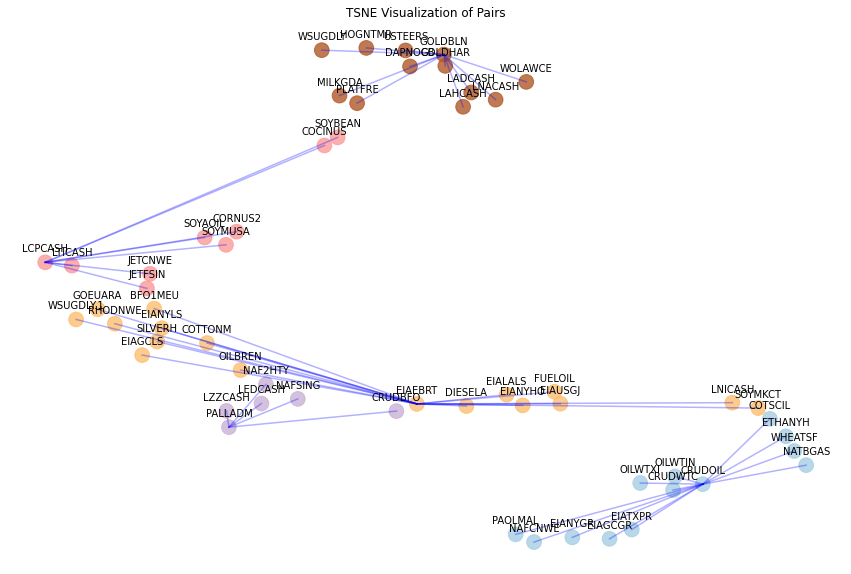

In [21]:
# TSNE Visualization
stocks = np.unique(pairs)
X_data = pd.DataFrame(index=X.index, data=X).T
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_data.T.loc[stocks]

X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(X_pairs)

# Plot
plt.figure(1, facecolor='white',figsize=(15,10))
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    ticker2 = pair[0]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='b');
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('TSNE Visualization of Pairs'); 

for x,y,name in zip(X_tsne[:,0],X_tsne[:,1],X_pairs.index):
    label = name
    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')
plt.show()

In [22]:
"""
pairs = pd.DataFrame(pairs)
pairs.to_excel("clustering_pairs.xlsx")

"""

'\npairs = pd.DataFrame(pairs)\npairs.to_excel("clustering_pairs.xlsx")\n\n'

# <u> Part 2: Structural Break Identification

In [23]:
# set theme
import seaborn as sns

plt.style.use('seaborn')
sns.set_style('darkgrid')

In [24]:
# Data import, slicing and transformation

raw_data = pd.read_excel('commod_data.xlsx', sheet_name = 'Sheet1', index_col='Date')

raw_data_returns = np.log(raw_data).diff().dropna()

raw_data_prices = raw_data.dropna(axis=1)
raw_data_prices

,CRUDOIL,GOLDBLN,LCPCASH,EIAEBRT,OILBREN,WHEATSF,LAHCASH,LNICASH,CORNUS2,SILVERH,...,FUELOIL,NATBGAS,EEXPEAK,DAPNOCB,WSUGDLY,WOLAWCE,WSUGDLY.1,PAOLMAL,USTEERS,MILKGDA
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-01,123.26,914.40,8073.0,124.16,123.98,5.83,2884.45,18172.0,5.15,17.57,...,3.4143,1.156113,126.982151,1195.60,831,804.64320,0.1489,1100.0,96.92,1.4400
2008-08-04,121.41,906.20,7734.0,121.87,121.63,5.53,2831.00,17887.0,4.85,17.09,...,3.3251,1.115142,108.001374,1192.80,831,805.80960,0.1423,1050.0,96.94,1.4400
2008-08-05,119.17,880.40,7768.0,116.50,116.88,5.92,2849.50,17474.0,4.75,16.68,...,3.2595,1.085193,110.651676,1192.80,831,792.33120,0.1476,1000.0,96.94,1.4400
2008-08-06,118.58,878.40,7767.0,114.47,114.62,5.83,2855.75,17678.0,4.60,16.50,...,3.2155,1.078347,122.037714,1192.80,831,785.76480,0.1499,1000.0,97.00,1.4400
2008-08-07,120.02,872.85,7810.0,116.94,117.00,6.21,2868.25,18749.0,4.72,16.26,...,3.2115,1.060588,109.358182,1192.80,831,767.87190,0.1456,1015.0,97.59,1.4400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,99.49,1898.40,9783.8,99.27,102.22,10.71,3073.50,32607.0,7.79,23.60,...,4.2167,1.950124,241.391126,1047.20,473,976.78985,0.1894,1990.0,143.02,1.7550
2022-04-26,101.70,1905.32,9863.5,102.89,105.08,10.92,3048.60,33055.0,7.79,23.54,...,4.5100,2.064209,254.079155,1047.20,473,977.88345,0.1898,1940.0,143.02,1.7075
2022-04-27,102.02,1885.36,9866.5,103.30,105.33,10.90,3080.70,33281.0,7.92,23.37,...,4.8035,1.871173,232.751367,1047.20,473,972.87985,0.1897,1940.0,143.02,1.7275


In [25]:
# Dataframe for unique pairs
"""
unique_pairs = pd.read_excel('final_pairs.xlsx', sheet_name='Sheet1')
selected_pairs = unique_pairs["Concat"].tolist()
print(selected_pairs)
"""
# Using cointegrated pairs with less than 1% p-value

# initializing the list with tuples
string_tuples = pairs

# function that converts tuple to string
def join_tuple_string(strings_tuple) -> str:
    return '-'.join(strings_tuple)

# joining all the tuples
result = map(join_tuple_string, string_tuples)

# converting and printing the result
selected_pairs = list(result)
selected_pairs

['EIAEBRT-OILBREN',
 'EIAEBRT-LNICASH',
 'EIAEBRT-SILVERH',
 'EIAEBRT-EIAUSGJ',
 'EIAEBRT-BFO1MEU',
 'EIAEBRT-GOEUARA',
 'EIAEBRT-RHODNWE',
 'EIAEBRT-COTTONM',
 'EIAEBRT-EIALALS',
 'EIAEBRT-EIANYHO',
 'EIAEBRT-EIANYLS',
 'EIAEBRT-EIAGCLS',
 'EIAEBRT-SOYMKCT',
 'EIAEBRT-DIESELA',
 'EIAEBRT-FUELOIL',
 'EIAEBRT-WSUGDLY.1',
 'CRUDOIL-WHEATSF',
 'CRUDOIL-OILWTIN',
 'CRUDOIL-NAFCNWE',
 'CRUDOIL-COTSCIL',
 'CRUDOIL-CRUDWTC',
 'CRUDOIL-ETHANYH',
 'CRUDOIL-EIATXPR',
 'CRUDOIL-EIANYGR',
 'CRUDOIL-EIAGCGR',
 'CRUDOIL-OILWTXI',
 'CRUDOIL-NATBGAS',
 'CRUDOIL-PAOLMAL',
 'GOLDBLN-LAHCASH',
 'GOLDBLN-PLATFRE',
 'GOLDBLN-GOLDHAR',
 'GOLDBLN-LADCASH',
 'GOLDBLN-HOGNTMR',
 'GOLDBLN-LNACASH',
 'GOLDBLN-DAPNOCB',
 'GOLDBLN-WSUGDLY',
 'GOLDBLN-WOLAWCE',
 'GOLDBLN-USTEERS',
 'GOLDBLN-MILKGDA',
 'LCPCASH-CORNUS2',
 'LCPCASH-SOYBEAN',
 'LCPCASH-COCINUS',
 'LCPCASH-JETCNWE',
 'LCPCASH-LTICASH',
 'LCPCASH-SOYAOIL',
 'LCPCASH-JETFSIN',
 'LCPCASH-SOYMUSA',
 'PALLADM-LZZCASH',
 'PALLADM-CRUDBFO',
 'PALLADM-NAF2HTY'

## Parsing Function

In [26]:
# Function to parse concatenated pairs 
def parse_pair(pair):
    s1 = pair[:pair.find('-')]
    s2 = pair[pair.find('-')+1:]
    return s1,s2

## Visualization of the structural break process using 'EIAEBRT-BFO1MEU' as example

<AxesSubplot:xlabel='Date'>

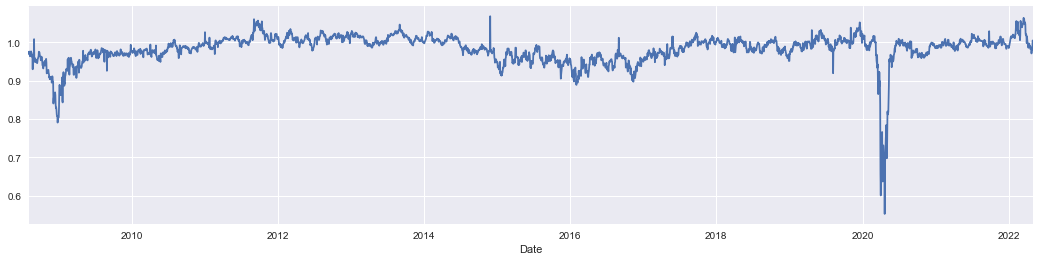

In [27]:
# step 1: we first identify the spread ratio

pair = 'EIAEBRT-BFO1MEU'
s1,s2 = parse_pair(pair)
spread = raw_data_prices[s1]/raw_data_prices[s2]

spread.plot(figsize=(18,4))

In [28]:
# step 2: we fit the model with the given conditions

import statsmodels.api as sm

mod = sm.tsa.MarkovRegression(spread, k_regimes=2, switching_variance=True)
res = mod.fit(search_reps=100)

In [29]:
print(res.summary())

                        Markov Switching Model Results                        
Dep. Variable:                      y   No. Observations:                 3586
Model:               MarkovRegression   Log Likelihood                8465.914
Date:                Sun, 26 Jun 2022   AIC                         -16919.828
Time:                        01:23:30   BIC                         -16882.720
Sample:                    08-01-2008   HQIC                        -16906.601
                         - 04-29-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0012      0.000   2949.957      0.000       1.001       1.002
sigma2         0.0002   6.65e-06     23.653      0.0

In [30]:
# Need to research more on the expected durations. Could be used to set the dates for high and low regime periods.

res.expected_durations

array([134.09909463,  96.03853385])

Text(0.5, 1.0, 'Probability of high-mean regime')

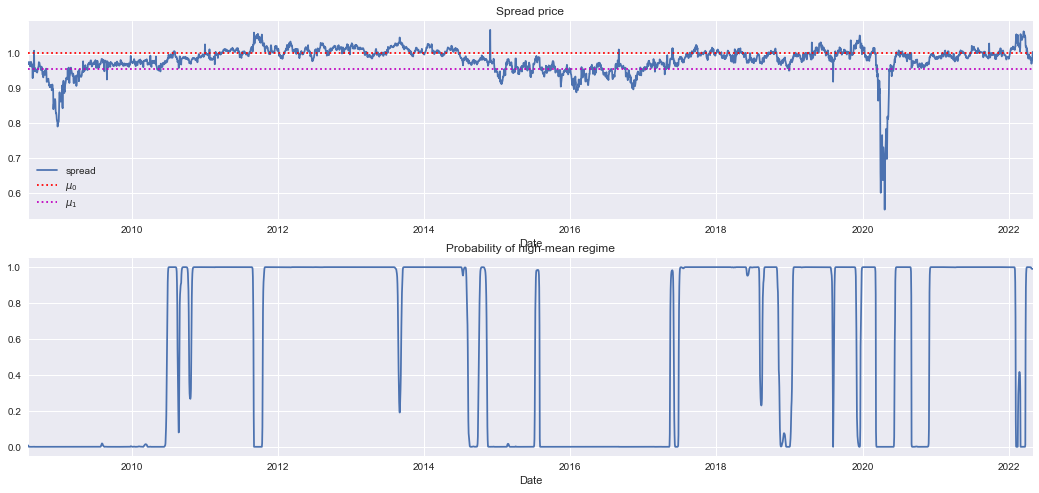

In [31]:
# step 3: we plot the graphs to vizualise the  

fig, axs = plt.subplots(2,1,figsize=(18,8))
spread.plot(ax=axs[0], label='spread')
axs[0].axhline(y=res.params['const[0]'], label=r'$\mu_0$', linestyle='dotted', c='r')
axs[0].axhline(y=res.params['const[1]'], label=r'$\mu_1$', linestyle='dotted', c='m')
axs[0].set_title('Spread price')
axs[0].legend()
res.smoothed_marginal_probabilities[0].plot(ax=axs[1])
axs[1].set_title('Probability of high-mean regime')

## Now, we just run a loop to get the dates of the structural breaks for all pairs for both train and test set

In [32]:
# Function stuctural breaks

def structural_break(pair):
    s1,s2 = parse_pair(pair)
    spread = raw_data_prices[s1]/raw_data_prices[s2]
    
    mod = sm.tsa.MarkovRegression(spread, k_regimes=2,switching_variance=True)
    res = mod.fit(search_reps=100)
    
    regime = pd.DataFrame(res.smoothed_marginal_probabilities)
    regime['Signal'] = regime[0].apply(lambda x: round(x))
    regime['Position'] = regime['Signal'].diff()
    
    dates = []
    for i in range(len(regime)):
        if regime['Position'][i] != 0:
            dates.append(regime.index[i])
    
    break_dates = pd.Series(dates, name=pair)
    
    return break_dates

In [33]:
# Running the function across all the pairs and merging them into one dataframe

struc_break_dates = pd.DataFrame()
#result_train = pd.DataFrame(structural_break_train('EIAEBRT-BFO1MEU'))

for pair in selected_pairs:
    try:
        struc_break_dates = pd.concat([struc_break_dates, structural_break(pair)], axis=1)
  
    except:
        continue

In [34]:
struc_break_dates

,EIAEBRT-OILBREN,EIAEBRT-LNICASH,EIAEBRT-SILVERH,EIAEBRT-BFO1MEU,EIAEBRT-GOEUARA,EIAEBRT-RHODNWE,EIAEBRT-COTTONM,EIAEBRT-EIALALS,EIAEBRT-SOYMKCT,EIAEBRT-DIESELA,...,LCPCASH-JETCNWE,LCPCASH-LTICASH,LCPCASH-SOYAOIL,LCPCASH-JETFSIN,LCPCASH-SOYMUSA,PALLADM-LZZCASH,PALLADM-CRUDBFO,PALLADM-NAF2HTY,PALLADM-NAFSING,PALLADM-LEDCASH
0,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,...,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01,2008-08-01
1,2008-09-01,2008-11-13,2008-12-18,2010-06-28,2009-02-27,2020-01-14,2008-12-17,2020-03-31,2008-11-17,2020-03-31,...,2015-12-09,2008-10-23,NaT,2009-03-03,2008-09-11,2010-04-29,2014-11-11,2008-10-15,2008-10-13,2018-09-21
2,2008-09-02,2011-05-26,2009-01-05,2010-08-19,2009-03-19,NaT,2009-02-06,2020-04-01,2009-09-17,2020-04-01,...,2016-04-29,2009-03-13,NaT,2009-03-18,2008-09-19,2018-10-31,NaT,2014-10-13,2014-10-10,NaT
3,2008-10-15,2011-06-24,2009-01-20,2010-08-27,2009-04-06,NaT,2010-05-17,2020-04-21,2014-08-20,2020-04-21,...,2016-11-08,2009-05-07,NaT,2009-04-08,2008-10-16,NaT,NaT,NaT,NaT,NaT
4,2008-10-16,2011-08-10,2009-03-30,2010-10-15,2011-11-10,NaT,2011-07-12,2020-04-22,2014-09-24,2020-04-22,...,2016-12-06,2009-06-24,NaT,2009-05-08,2009-10-20,NaT,NaT,NaT,NaT,NaT
5,2008-11-27,2014-11-18,2010-09-21,2010-10-26,2011-11-30,NaT,2014-12-18,NaT,2014-11-11,NaT,...,2017-05-31,2010-09-15,NaT,2009-07-13,2012-05-01,NaT,NaT,NaT,NaT,NaT
6,2009-02-05,2016-05-06,2012-03-07,2011-09-02,2012-06-12,NaT,2018-09-18,NaT,2015-04-28,NaT,...,2017-11-01,2010-11-18,NaT,2011-03-08,2017-08-01,NaT,NaT,NaT,NaT,NaT
7,2009-02-12,2016-07-01,2012-05-30,2011-10-19,2012-07-13,NaT,2018-10-30,NaT,2015-06-04,NaT,...,2020-02-27,2011-01-25,NaT,2011-06-23,2018-02-08,NaT,NaT,NaT,NaT,NaT
8,2009-02-23,2016-12-20,2012-07-16,2013-08-27,2012-09-19,NaT,2019-04-29,NaT,2017-10-26,NaT,...,2022-01-28,2011-06-02,NaT,2011-08-08,2019-02-05,NaT,NaT,NaT,NaT,NaT
9,2011-09-02,2017-08-09,2012-08-27,2013-09-09,2012-11-01,NaT,2019-10-01,NaT,2018-02-09,NaT,...,NaT,2011-10-04,NaT,2014-11-28,2019-05-24,NaT,NaT,NaT,NaT,NaT


In [35]:
struc_break_dates.to_csv("Sructural_Breaks.csv")

# <u> Part 3: Building Trading Models

## 3.1 SVM based upon the two-step Engle–Granger method

In [36]:
final_pairs = struc_break_dates.columns.to_list()
final_pairs

['EIAEBRT-OILBREN',
 'EIAEBRT-LNICASH',
 'EIAEBRT-SILVERH',
 'EIAEBRT-BFO1MEU',
 'EIAEBRT-GOEUARA',
 'EIAEBRT-RHODNWE',
 'EIAEBRT-COTTONM',
 'EIAEBRT-EIALALS',
 'EIAEBRT-SOYMKCT',
 'EIAEBRT-DIESELA',
 'EIAEBRT-WSUGDLY.1',
 'CRUDOIL-WHEATSF',
 'CRUDOIL-NAFCNWE',
 'CRUDOIL-COTSCIL',
 'CRUDOIL-ETHANYH',
 'CRUDOIL-NATBGAS',
 'CRUDOIL-PAOLMAL',
 'GOLDBLN-LAHCASH',
 'GOLDBLN-PLATFRE',
 'GOLDBLN-LADCASH',
 'GOLDBLN-HOGNTMR',
 'GOLDBLN-LNACASH',
 'GOLDBLN-DAPNOCB',
 'GOLDBLN-WSUGDLY',
 'GOLDBLN-WOLAWCE',
 'GOLDBLN-USTEERS',
 'GOLDBLN-MILKGDA',
 'LCPCASH-CORNUS2',
 'LCPCASH-SOYBEAN',
 'LCPCASH-COCINUS',
 'LCPCASH-JETCNWE',
 'LCPCASH-LTICASH',
 'LCPCASH-SOYAOIL',
 'LCPCASH-JETFSIN',
 'LCPCASH-SOYMUSA',
 'PALLADM-LZZCASH',
 'PALLADM-CRUDBFO',
 'PALLADM-NAF2HTY',
 'PALLADM-NAFSING',
 'PALLADM-LEDCASH']

In [37]:
#Function to get the hedge ratios across the structural breaks for each pair using SVR

from sklearn.svm import LinearSVR

def SVM_regression(pair):
    s1,s2 = parse_pair(pair)
    
    coefficient = []
    
    try:
    
        for i in range(len(struc_break_dates[pair].dropna())):
            s1_price = raw_data_prices[s1].loc[struc_break_dates[pair].dropna()[i]:struc_break_dates[pair].dropna()[i+1]]
            s2_price = raw_data_prices[s2].loc[struc_break_dates[pair].dropna()[i]:struc_break_dates[pair].dropna()[i+1]]

            regressor = LinearSVR()
            res = regressor.fit(np.array(s1_price).reshape(-1,1), np.array(s2_price).reshape(-1,1).ravel())

            coefficient += res.coef_.flatten().tolist()
            
    except:
        pass
    
    hedge_ratios = pd.Series(coefficient, name=pair)
        
    return hedge_ratios

In [38]:
# Running the function across all the pairs and merging them into one dataframe

hedge_ratios = pd.DataFrame()

for pair in final_pairs:
    hedge_ratios = pd.concat([hedge_ratios, SVM_regression(pair)], axis=1)
    
hedge_ratios

,EIAEBRT-OILBREN,EIAEBRT-LNICASH,EIAEBRT-SILVERH,EIAEBRT-BFO1MEU,EIAEBRT-GOEUARA,EIAEBRT-RHODNWE,EIAEBRT-COTTONM,EIAEBRT-EIALALS,EIAEBRT-SOYMKCT,EIAEBRT-DIESELA,...,LCPCASH-JETCNWE,LCPCASH-LTICASH,LCPCASH-SOYAOIL,LCPCASH-JETFSIN,LCPCASH-SOYMUSA,PALLADM-LZZCASH,PALLADM-CRUDBFO,PALLADM-NAF2HTY,PALLADM-NAFSING,PALLADM-LEDCASH
0,1.005345,172.263294,0.068274,0.963151,9.490316,13.870551,0.003947,0.023916,3.233107,0.026099,...,0.093522,2.795621,NaN,0.018356,0.047377,5.943403,0.094603,3.254316,0.385366,2.643889
1,0.949786,256.301423,0.284922,1.009398,8.415214,NaN,0.008834,0.070623,5.758824,0.066866,...,0.076507,3.298586,NaN,0.013559,0.050106,2.968020,NaN,1.190417,0.125818,NaN
2,1.049702,194.609773,0.263068,1.021095,8.895786,NaN,0.008350,0.031138,3.764518,0.031757,...,0.100141,2.650343,NaN,0.014814,0.043478,NaN,NaN,NaN,NaN,NaN
3,1.015159,205.516760,0.266138,1.014358,8.248435,NaN,0.019511,0.022923,5.746908,0.022915,...,0.082839,2.949457,NaN,0.013215,0.079501,NaN,NaN,NaN,NaN,NaN
4,0.983404,153.626439,0.233966,1.024072,8.981088,NaN,0.007174,NaN,4.197146,NaN,...,0.088284,2.453947,NaN,0.014137,0.039735,NaN,NaN,NaN,NaN,NaN
5,0.953534,218.415975,0.341000,0.999757,8.489827,NaN,0.004404,NaN,5.971940,NaN,...,0.080795,3.055302,NaN,0.012177,0.061845,NaN,NaN,NaN,NaN,NaN
6,1.005319,178.920006,0.263379,0.961764,8.863978,NaN,0.009648,NaN,4.926853,NaN,...,0.100382,2.879999,NaN,0.013824,0.045974,NaN,NaN,NaN,NaN,NaN
7,0.935744,217.313121,0.297248,0.970257,8.564649,NaN,0.008544,NaN,5.142377,NaN,...,0.063093,3.220114,NaN,0.013202,0.049992,NaN,NaN,NaN,NaN,NaN
8,0.999415,190.941471,0.253069,0.965174,8.908366,NaN,0.009661,NaN,4.625146,NaN,...,NaN,2.667676,NaN,0.015636,0.047916,NaN,NaN,NaN,NaN,NaN
9,0.981111,215.654885,0.300586,0.986712,8.427575,NaN,0.010531,NaN,5.464138,NaN,...,NaN,3.120620,NaN,0.009783,0.055865,NaN,NaN,NaN,NaN,NaN


### Now, we want to generate the spread for each pair across the entire sample period based on the previously generated hedge ratios from the SVR model.

### $$ Spread = log(a) – nlog(b)$$,  where ‘a’ and ‘b’ are prices of futures A and B respectively, and n is the regression coefficient (hedge ratio)

In [39]:
# So we start by creating a function for generating the hedge ratio against the sample period

def hedge_ratio(pair):
    s1,s2 = parse_pair(pair)
    try:
        date_hedge = pd.DataFrame()

        for i in range(len(struc_break_dates[pair].dropna())):
            hedge_ratio_df = raw_data_prices.loc[struc_break_dates[pair].dropna()[i]:struc_break_dates[pair].dropna()[i+1]].index.to_frame(index=False, name='Date')
            hedge_ratio_df[pair] = hedge_ratios[pair][i]

            date_hedge = date_hedge.append(hedge_ratio_df)
            
        date_hedge = pd.concat([date_hedge, raw_data_prices.loc[struc_break_dates[pair].dropna()[i]:raw_data_prices[s1].index[-1]].index.to_frame(index=False, name='Date')])
        
    except:
        pass

    return date_hedge.append(raw_data_prices.loc[struc_break_dates[pair].dropna()[i]:raw_data_prices[s1].index[-1]].index.to_frame(index=False))

In [40]:
# Next we run the function against all the pairs
merged_hedge_ratios = hedge_ratio('EIAEBRT-OILBREN')
for pair in final_pairs[1:]:
    merged_hedge_ratios = pd.merge(merged_hedge_ratios,hedge_ratio(pair), on='Date')

In [41]:
# applying ffill() method to fill the missing values, dropping duplicates and setting date as index so as to get a complete hedge ratio dataframe
merged_hedge_ratios = merged_hedge_ratios.ffill(axis = 0)
merged_hedge_ratios = merged_hedge_ratios.drop_duplicates(subset='Date')
merged_hedge_ratios = merged_hedge_ratios.set_index('Date')
merged_hedge_ratios

,EIAEBRT-OILBREN,EIAEBRT-LNICASH,EIAEBRT-SILVERH,EIAEBRT-BFO1MEU,EIAEBRT-GOEUARA,EIAEBRT-RHODNWE,EIAEBRT-COTTONM,EIAEBRT-EIALALS,EIAEBRT-SOYMKCT,EIAEBRT-DIESELA,...,LCPCASH-COCINUS,LCPCASH-JETCNWE,LCPCASH-LTICASH,LCPCASH-JETFSIN,LCPCASH-SOYMUSA,PALLADM-LZZCASH,PALLADM-CRUDBFO,PALLADM-NAF2HTY,PALLADM-NAFSING,PALLADM-LEDCASH
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-01,1.005345,172.263294,0.068274,0.963151,9.490316,13.870551,0.003947,0.023916,3.233107,0.026099,...,0.339010,0.093522,2.795621,0.018356,0.047377,5.943403,0.094603,3.254316,0.385366,2.643889
2008-08-04,1.005345,172.263294,0.068274,0.963151,9.490316,13.870551,0.003947,0.023916,3.233107,0.026099,...,0.339010,0.093522,2.795621,0.018356,0.047377,5.943403,0.094603,3.254316,0.385366,2.643889
2008-08-05,1.005345,172.263294,0.068274,0.963151,9.490316,13.870551,0.003947,0.023916,3.233107,0.026099,...,0.339010,0.093522,2.795621,0.018356,0.047377,5.943403,0.094603,3.254316,0.385366,2.643889
2008-08-06,1.005345,172.263294,0.068274,0.963151,9.490316,13.870551,0.003947,0.023916,3.233107,0.026099,...,0.339010,0.093522,2.795621,0.018356,0.047377,5.943403,0.094603,3.254316,0.385366,2.643889
2008-08-07,1.005345,172.263294,0.068274,0.963151,9.490316,13.870551,0.003947,0.023916,3.233107,0.026099,...,0.339010,0.093522,2.795621,0.018356,0.047377,5.943403,0.094603,3.254316,0.385366,2.643889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,0.972337,186.422873,0.208284,0.950682,8.356047,13.870551,0.009690,0.022923,5.204545,0.022915,...,0.466495,0.063093,2.962348,0.014057,0.053697,2.968020,0.094603,1.190417,0.125818,2.643889
2022-04-26,0.972337,186.422873,0.208284,0.950682,8.356047,13.870551,0.009690,0.022923,5.204545,0.022915,...,0.466495,0.063093,2.962348,0.014057,0.053697,2.968020,0.094603,1.190417,0.125818,2.643889
2022-04-27,0.972337,186.422873,0.208284,0.950682,8.356047,13.870551,0.009690,0.022923,5.204545,0.022915,...,0.466495,0.063093,2.962348,0.014057,0.053697,2.968020,0.094603,1.190417,0.125818,2.643889


In [42]:
# Now we can proceed to generate a function to calcuate the spread series for each pair

def spread_series(pair):
    s1,s2 = parse_pair(pair)
    
    spread_series = np.log(raw_data_prices[s1]) - (merged_hedge_ratios[pair] * np.log(raw_data_prices[s2]))
    
    return spread_series

In [43]:
# Creation of the spread dataframe

spread_df = pd.DataFrame()

try:
    for pair in final_pairs:
        spread_df[pair] = spread_series(pair)
except:
    pass
    
spread_df

,EIAEBRT-OILBREN,EIAEBRT-LNICASH,EIAEBRT-SILVERH,EIAEBRT-BFO1MEU,EIAEBRT-GOEUARA,EIAEBRT-RHODNWE,EIAEBRT-COTTONM,EIAEBRT-EIALALS,EIAEBRT-SOYMKCT,EIAEBRT-DIESELA,...,GOLDBLN-PLATFRE,GOLDBLN-LADCASH,GOLDBLN-HOGNTMR,GOLDBLN-LNACASH,GOLDBLN-DAPNOCB,GOLDBLN-WSUGDLY,GOLDBLN-WOLAWCE,GOLDBLN-USTEERS,GOLDBLN-MILKGDA,LCPCASH-CORNUS2
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-01,-0.024311,-1684.674326,4.625884,0.153389,-61.800139,-120.135948,4.823333,4.791609,-14.391286,4.789440,...,-1.547531,-15.803349,6.361620,-12.764240,3.424851,3.059741,1.310669,6.232874,6.817902,8.994689
2008-08-04,-0.023688,-1681.969846,4.609159,0.151559,-61.808145,-119.767454,4.804842,4.773644,-14.236417,4.771339,...,-1.495721,-15.770731,6.353623,-12.735512,3.416965,3.050733,1.300469,6.223840,6.808894,8.951848
2008-08-05,-0.028703,-1677.990817,4.565753,0.145932,-61.302511,-119.636939,4.759778,4.729322,-14.222736,4.726874,...,-1.508513,-15.782093,6.322777,-12.774382,3.388082,3.021849,1.285471,6.194956,6.780010,8.956255
2008-08-06,-0.026652,-1680.007832,4.548916,0.146649,-61.206920,-119.476687,4.742137,4.712131,-14.114786,4.709744,...,-1.544493,-15.801889,6.319923,-12.786602,3.385807,3.019575,1.290047,6.192602,6.777736,8.956157
2008-08-07,-0.025965,-1690.118923,4.571264,0.152111,-61.240062,-119.455339,4.763361,4.733464,-14.179510,4.731439,...,-1.542411,-15.827091,6.312523,-12.799137,3.379469,3.013237,1.302671,6.185488,6.771397,8.961653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,0.098716,-1932.761279,3.939407,0.198918,-54.037023,-131.604897,4.595007,4.566800,-27.383195,4.566397,...,-0.138104,-1.295363,7.272601,0.879947,5.256400,4.105304,2.594639,7.101737,7.548384,9.185884
2022-04-26,0.107702,-1935.269361,3.975754,0.208501,-54.438986,-131.417405,4.630752,4.601981,-27.347378,4.601254,...,-0.132005,-1.289541,7.276186,0.884007,5.260038,4.108942,2.597472,7.105375,7.552042,9.193997
2022-04-27,0.109368,-1936.535636,3.981241,0.210219,-54.546225,-131.413428,4.634377,4.605333,-27.343401,4.604628,...,-0.160861,-1.289088,7.266289,0.873758,5.249507,4.098411,2.590633,7.094844,7.541502,9.194280


In [44]:
spread_df.columns.to_series().to_csv('final_pairs_svm.csv')

### Now that we have our spreads, we can generate our 'Signals'.

So essentiallty our signal generated based on the 42-day rolling mean plus the 42-day rolling standard deviation. So if the spread at t is greater than this "sum of rolling" then we take a short position and vice versa.

In [45]:
def signals(pair, spread_df):
    s1,s2 = parse_pair(pair)
    
    df = spread_df[pair].to_frame()
    df['sum of rolling'] = df[pair].rolling(window=42).mean() + df[pair].rolling(window=42).std()
    df['Signals'] = 0
    df = df.dropna()
    
    for i in range(len(df[pair])):
        if df[pair][i] > df['sum of rolling'][i]:
            df['Signals'][i] = 0
        elif df[pair][i] < df['sum of rolling'][i]:
            df['Signals'][i]= 1
    
    pair_signals = pd.Series(df['Signals'], name=pair)
    
    return pair_signals

In [46]:
# Now to create a dataframe of positions for the final pairs
pair_signals = pd.DataFrame()

for pair in spread_df.columns:
    pair_signals[pair] = signals(pair, spread_df)

pair_signals

,EIAEBRT-OILBREN,EIAEBRT-LNICASH,EIAEBRT-SILVERH,EIAEBRT-BFO1MEU,EIAEBRT-GOEUARA,EIAEBRT-RHODNWE,EIAEBRT-COTTONM,EIAEBRT-EIALALS,EIAEBRT-SOYMKCT,EIAEBRT-DIESELA,...,GOLDBLN-PLATFRE,GOLDBLN-LADCASH,GOLDBLN-HOGNTMR,GOLDBLN-LNACASH,GOLDBLN-DAPNOCB,GOLDBLN-WSUGDLY,GOLDBLN-WOLAWCE,GOLDBLN-USTEERS,GOLDBLN-MILKGDA,LCPCASH-CORNUS2
Date,,,,,,,,,,,,,,,,,,,,,
2008-09-29,1,0,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
2008-09-30,1,0,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
2008-10-01,1,0,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
2008-10-02,1,0,1,1,0,0,1,1,0,1,...,0,0,1,0,1,1,1,1,1,1
2008-10-03,1,0,1,1,0,0,1,1,0,1,...,0,0,1,0,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,1,1,1,1,1
2022-04-26,1,1,1,1,1,0,1,1,1,1,...,0,0,1,1,1,1,1,1,1,1
2022-04-27,1,1,1,1,1,0,1,1,1,1,...,0,0,1,1,1,1,1,1,1,1


In [47]:
pair_positions = pair_signals.diff().dropna()
pair_positions

,EIAEBRT-OILBREN,EIAEBRT-LNICASH,EIAEBRT-SILVERH,EIAEBRT-BFO1MEU,EIAEBRT-GOEUARA,EIAEBRT-RHODNWE,EIAEBRT-COTTONM,EIAEBRT-EIALALS,EIAEBRT-SOYMKCT,EIAEBRT-DIESELA,...,GOLDBLN-PLATFRE,GOLDBLN-LADCASH,GOLDBLN-HOGNTMR,GOLDBLN-LNACASH,GOLDBLN-DAPNOCB,GOLDBLN-WSUGDLY,GOLDBLN-WOLAWCE,GOLDBLN-USTEERS,GOLDBLN-MILKGDA,LCPCASH-CORNUS2
Date,,,,,,,,,,,,,,,,,,,,,
2008-09-30,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-01,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
2008-10-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
2008-10-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-26,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Back-Testing

Basically, if the position is -1, then we are shorting the spread and hence price of s2 times quantity which in this case is a 100 x hedge ratio. The rationale is that we sell 100 shares of s1 and the equivalent nominal quantity we need to buy of s2 is 100 x hedge ratio. Vice-versa for when we want to long the spread.

In [48]:
def profit(pair):
    s1,s2 = parse_pair(pair)
    
    series = pd.Series(merged_hedge_ratios[pair], name = 'Hedge Ratio')
    combine_df = pd.concat([raw_data_prices[s1], raw_data_prices[s2], pair_positions[pair], series], axis=1).dropna()
    
    combine_df['PnL'] = 0

    for i in range(len(combine_df)):
        if combine_df[pair][i] == -1:
            combine_df['PnL'][i] = (100*combine_df['Hedge Ratio'][i]*combine_df[s1][i]) - (100*combine_df[s2][i])
        elif combine_df[pair][i] == 1:
            combine_df['PnL'][i] =  (100*combine_df[s2][i]) - (100*combine_df['Hedge Ratio'][i]*combine_df[s1][i])
        else:
            combine_df['PnL'][i] = 0
            
    PnL = pd.Series(combine_df['PnL'], name=pair)
    
    return PnL

In [49]:
profit(pair)

Date
2008-09-30    0
2008-10-01    0
2008-10-02    0
2008-10-03    0
2008-10-06    0
             ..
2022-04-25    0
2022-04-26    0
2022-04-27    0
2022-04-28    0
2022-04-29    0
Name: LCPCASH-CORNUS2, Length: 3501, dtype: int64

## Accumulated Profit for the period

In [50]:
pair_profits = pd.DataFrame()

for pair in spread_df.columns:
    pair_profits[pair] = profit(pair)

pair_profits.sum()

EIAEBRT-OILBREN         9835
EIAEBRT-LNICASH      1964539
EIAEBRT-SILVERH         1651
EIAEBRT-BFO1MEU         7986
EIAEBRT-GOEUARA       107524
EIAEBRT-RHODNWE     -2730105
EIAEBRT-COTTONM          107
EIAEBRT-EIALALS          118
EIAEBRT-SOYMKCT         8736
EIAEBRT-DIESELA          154
EIAEBRT-WSUGDLY.1          0
CRUDOIL-WHEATSF         -384
CRUDOIL-NAFCNWE       -33509
CRUDOIL-COTSCIL          274
CRUDOIL-ETHANYH          316
CRUDOIL-NATBGAS          161
CRUDOIL-PAOLMAL       -27877
GOLDBLN-LAHCASH       219348
GOLDBLN-PLATFRE       142154
GOLDBLN-LADCASH       284689
GOLDBLN-HOGNTMR        -8373
GOLDBLN-LNACASH       193595
GOLDBLN-DAPNOCB        81317
GOLDBLN-WSUGDLY         4212
GOLDBLN-WOLAWCE       -51716
GOLDBLN-USTEERS          909
GOLDBLN-MILKGDA           40
LCPCASH-CORNUS2         -412
dtype: int64

In [66]:
pair_profits_2 = pair_profits.iloc[:,-18:-3]
pair_profits_2.sum().to_csv("profits_2.csv")

In [52]:
pair_profits['Daily PnL'] = pair_profits.sum(axis=1)
pair_profits['Daily PnL'].sum()

175289

In [53]:
pair_profits_2['Daily PnL'] = pair_profits_2.sum(axis=1)
pair_profits_2['Daily PnL'].sum()

804207

<AxesSubplot:xlabel='Date'>

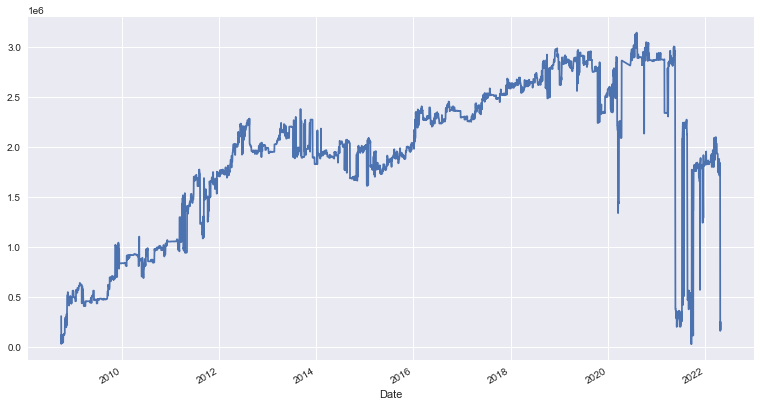

In [54]:
pair_profits['Daily PnL'].cumsum().plot(figsize=(13,7))

<AxesSubplot:xlabel='Date'>

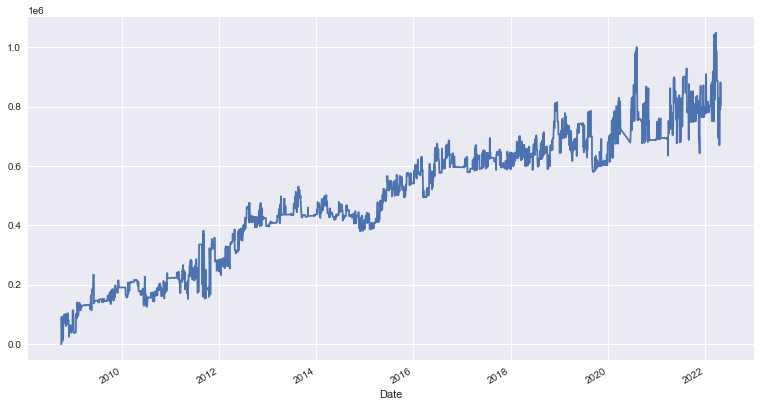

In [55]:
pair_profits_2['Daily PnL'].cumsum().plot(figsize=(13,7))

## <u>  Performance Metrics

### Top 3 performing pairs

In [56]:
# Best performing pairs in the train set

pair_profits[pair_profits.columns[:-1]].sum().nlargest(3)

EIAEBRT-LNICASH    1964539
GOLDBLN-LADCASH     284689
GOLDBLN-LAHCASH     219348
dtype: int64

In [57]:
pair_profits_2[pair_profits_2.columns[:-1]].sum().nlargest(3)

GOLDBLN-LADCASH    284689
GOLDBLN-LAHCASH    219348
GOLDBLN-LNACASH    193595
dtype: int64

In [58]:
# Initialising capital

initial_capital = float(100000)

In [59]:
# Generating terminal wealth

pair_profits['Terminal Wealth'] = initial_capital + pair_profits['Daily PnL'].cumsum()
pair_profits

,EIAEBRT-OILBREN,EIAEBRT-LNICASH,EIAEBRT-SILVERH,EIAEBRT-BFO1MEU,EIAEBRT-GOEUARA,EIAEBRT-RHODNWE,EIAEBRT-COTTONM,EIAEBRT-EIALALS,EIAEBRT-SOYMKCT,EIAEBRT-DIESELA,...,GOLDBLN-HOGNTMR,GOLDBLN-LNACASH,GOLDBLN-DAPNOCB,GOLDBLN-WSUGDLY,GOLDBLN-WOLAWCE,GOLDBLN-USTEERS,GOLDBLN-MILKGDA,LCPCASH-CORNUS2,Daily PnL,Terminal Wealth
Date,,,,,,,,,,,,,,,,,,,,,
2008-09-30,0,0,0,0,6046,302782,0,0,0,0,...,0,0,0,0,0,0,0,0,308828,408828.0
2008-10-01,0,0,0,0,-5183,-272127,0,0,0,0,...,0,0,0,0,0,0,0,0,-277310,131518.0
2008-10-02,0,0,0,0,0,0,0,0,0,0,...,-1584,0,63461,28008,159,-1175,25,0,88894,220412.0
2008-10-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2275,0,0,0,2275,222687.0
2008-10-06,0,0,0,0,0,0,0,0,0,0,...,2000,0,-58094,-26728,0,0,0,0,-82822,139865.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-5103,1938467.0
2022-04-26,0,0,0,0,0,-1676285,0,0,0,0,...,0,0,0,0,0,0,0,0,-1676285,262182.0
2022-04-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,262182.0


In [60]:
# Generating terminal wealth

pair_profits_2['Terminal Wealth'] = initial_capital + pair_profits_2['Daily PnL'].cumsum()
pair_profits_2

,EIAEBRT-WSUGDLY.1,CRUDOIL-WHEATSF,CRUDOIL-NAFCNWE,CRUDOIL-COTSCIL,CRUDOIL-ETHANYH,CRUDOIL-NATBGAS,CRUDOIL-PAOLMAL,GOLDBLN-LAHCASH,GOLDBLN-PLATFRE,GOLDBLN-LADCASH,GOLDBLN-HOGNTMR,GOLDBLN-LNACASH,GOLDBLN-DAPNOCB,GOLDBLN-WSUGDLY,GOLDBLN-WOLAWCE,Daily PnL,Terminal Wealth
Date,,,,,,,,,,,,,,,,,
2008-09-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100000.0
2008-10-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100000.0
2008-10-02,0,0,0,0,0,0,0,0,0,0,-1584,0,63461,28008,159,90044,190044.0
2008-10-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2275,2275,192319.0
2008-10-06,0,0,0,0,0,0,0,0,0,0,2000,0,-58094,-26728,0,-82822,109497.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,0,0,-5103,0,0,0,0,0,0,0,0,0,0,0,0,-5103,891100.0
2022-04-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,891100.0
2022-04-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,891100.0


In [61]:
#portfolio = pair_profits['Terminal Wealth']
#portfolio.to_csv('Terminal Wealth.csv')

### Generating backtesting performance tear sheet

In [62]:
import pyfolio as pf

# Needed to include the initial capital; this was included manually

ter_wealth = pd.read_csv('Terminal Wealth.csv', index_col='Date')
ter_wealth.index = pd.to_datetime(ter_wealth.index, format='%d/%m/%y')
ter_wealth

,Terminal Wealth
Date,
2008-09-29,100000
2008-09-30,410506
2008-10-01,131541
2008-10-02,167301
2008-10-03,167301
...,...
2022-04-25,1930912
2022-04-26,253833
2022-04-27,253833


In [63]:
#Utility method takes in daily % pnl vector and computes pnl diagnostics
#daily % pnl is inputed as a dataframe, with date as index and corresponding pnl for that date as the value

def pnlPerformance(pnl, label):
    cumpnl = pnl.cumsum(skipna = True)
    import matplotlib.pyplot as plt
    import numpy as np
    sharpe = pnl.mean()/np.std(pnl)
    sharpe = sharpe*np.sqrt(252)
    print("")
    print ("PERFORMANCE STATISTICS FOR "+label);
    print("Daily annualized sharpe: "+str(sharpe))
    print ("Average annual returns: "+str(pnl.mean()*252*100)+"%")
    print ("Total returns: "+str(pnl.sum()*100)+"%");
    highwatermark_df = cumpnl.cummax();
    drawdown_df = cumpnl - highwatermark_df;
    maxdrawdown = drawdown_df.min();
    print ("Max drawdown: "+str(maxdrawdown*100)+"%");
    plt.plot(cumpnl.values, label = label);
    plt.legend();
    plt.title("Cumulative PNL chart")
    plt.show(block=False);


PERFORMANCE STATISTICS FOR Rolling_SVR_Strategy
Daily annualized sharpe: Terminal Wealth    0.698142
dtype: float64
Average annual returns: Terminal Wealth    206.823093
dtype: float64%
Total returns: Terminal Wealth    2873.363686
dtype: float64%
Max drawdown: Terminal Wealth   -134.043075
dtype: float64%


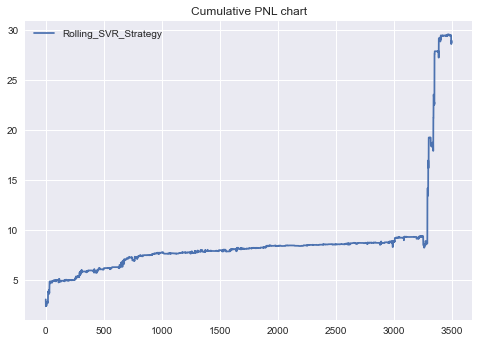

In [64]:
pnlPerformance(ter_wealth.pct_change().dropna(), 'Rolling_SVR_Strategy')


PERFORMANCE STATISTICS FOR Rolling_SVR_Strategy
Daily annualized sharpe: 0.583313557982667
Average annual returns: 49.322843195070085%
Total returns: 685.0394888204171%
Max drawdown: -51.90689096793935%


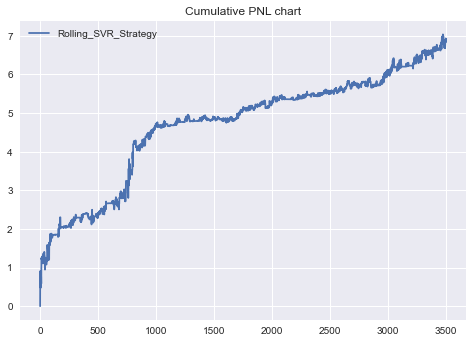

In [65]:
pnlPerformance(pair_profits_2['Terminal Wealth'].pct_change().dropna(), 'Rolling_SVR_Strategy')